# CS-577: Deep Learning. Homework 2

#### Student:             Jorge Gonzalez Lopez
#### CWID:                 A20474413
#### Semester:          Spring 2021

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import pickle

There are four types of nodes:
 - Multiplication Nodes (Linear nodes)
 - Sigmoid Nodes
 - Softmax Node
 - Loss Node

In [2]:
class LinearNode():
    
    def forward(self, X, W, b):
        
        Z = np.dot(W,X) + b
        self.X = X
        self.W = W
        self.b = b
        
        return Z
    
    def backward(self, dZ):
        
        dX = np.dot(dZ.T,self.W).T
        dW = np.dot(dZ,self.X.T)
        db = dZ.sum(axis=1, keepdims = True)
        self.dX = dX
        self.dW = dW
        self.db = db
        
        return dX, dW, db

In [3]:
class SigmoidNode:
    def forward(self,Z):
        A = (1 / (1 + np.exp(-Z)))
        self.A = A
        return A
    def backward(self,dA):
        dZ = (self.A * (1 - self.A)) * dA
        return dZ
        

In [4]:
class SoftmaxNode:
    def forward(self,Z):
        A = (np.exp(Z)/np.sum(np.exp(Z), axis = 0))
        self.A = A
        return A
    def backward(self,dA):
        dZ = dA
        return dZ

In [5]:
class LossNode:
    def forward(self, Y , A_L):
        self.Y = Y
        self.A_L = A_L
        E = - (1/Y.shape[1]) * np.sum(Y * np.log(A_L))
        self.E = E
        #Accuracy
        A = 0
        for i in range(Y.shape[1]):
            idx = np.argmax(A_L[:,i])
            A += Y[idx,i]
        A = 100 * A / Y.shape[1]
        
        self.A = A
        
        return self.E, self.A
    
    def backward(self):
        return self.A_L - self.Y

When creating a Model with a certain dimensions:
    - It automatically initializes the weights and biases.
    - It creates the fixed structure of 2 hidden layers with sigmoid activation and an output layer with softmax activation.

In [6]:
class Model:
    
    def __init__(self, dimensions):
        
        self.num_layers = len(dimensions)
        
        self.layer_neurons = dimensions
        
        
        self.parameters={}
    
        self.parameters['W1'] = np.random.randn(dimensions[1],dimensions[0])/10
        self.parameters['b1'] = np.random.randn(dimensions[1],1)/10
        self.parameters['W2'] = np.random.randn(dimensions[2],dimensions[1])/10
        self.parameters['b2'] = np.random.randn(dimensions[2],1)/10
        self.parameters['v'] = np.random.randn(dimensions[3],dimensions[2])/10
        self.parameters['v0'] = np.random.randn(dimensions[3],1)/10
        
        self.model = []
        
        self.model.append(LinearNode())
        self.model.append(SigmoidNode())
        
        self.model.append(LinearNode())
        self.model.append(SigmoidNode())
        
        self.model.append(LinearNode())
        self.model.append(SoftmaxNode())
        
        self.model.append(LossNode())
    
    def forward(self, X, Y):
        
        Z1 = self.model[0].forward(X, self.parameters['W1'], self.parameters['b1'])
        A1 = self.model[1].forward(Z1)
        
        Z2 = self.model[2].forward(A1, self.parameters['W2'], self.parameters['b2'])
        A2 = self.model[3].forward(Z2)
        
        Z3 = self.model[4].forward(A2, self.parameters['v'], self.parameters['v0'])
        A3 = self.model[5].forward(Z3)
        
        E, A = self.model[6].forward(Y,A3)
        
        return E, A
    
    def backward(self):
        
        dE = self.model[6].backward()
        
        dsoft = self.model[5].backward(dE) 
        dZ3, self.dv, self.dv0 = self.model[4].backward(dsoft)
        
        dsig = self.model[3].backward(dZ3)
        dZ2, self.dW2, self.db2 = self.model[2].backward(dsig)

        dsig = self.model[1].backward(dZ2)
        dZ1, self.dW1, self.db1 = self.model[0].backward(dsig)
    
    def params_update(self, learning_rate):
        
        self.parameters['W1'] -= learning_rate*self.dW1
        self.parameters['b1'] -= learning_rate*self.db1
        self.parameters['W2'] -= learning_rate*self.dW2
        self.parameters['b2'] -= learning_rate*self.db2
        self.parameters['v'] -= learning_rate*self.dv
        self.parameters['v0'] -= learning_rate*self.dv0
    
    def fit(self, X_t, Y_t, X_v, Y_v, learning_rate, iterations):
        
        loss = []
        val_loss = []
        accuracy = []
        val_accuracy = []

        for i in range(1, iterations+1):

            E, A = self.forward(X_t.T, Y_t.T)
            E_v, A_v = self.forward(X_v.T, Y_v.T)
            
            loss.append(E)
            val_loss.append(E_v)
            accuracy.append(A)
            val_accuracy.append(A_v)
            
            self.backward()
            self.params_update(learning_rate)
            
            if i % 10 == 0:
                print ("Iteration number %i / %i: Loss: %f, Acc: %f, Val. Loss: %f, Val. Acc: %f" %(i, iterations, E, A, E_v, A_v))

        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.iterations = iterations
    
    
    def print_results(self):
        
        plt.plot(range(self.iterations), self.loss)
        plt.plot(range(self.iterations), self.val_loss)
        plt.ylabel('Loss')
        plt.xlabel('Iterations')
        plt.legend(['Train', 'Val'])
        plt.show()

        plt.plot(range(self.iterations),self.accuracy)
        plt.plot(range(self.iterations),self.val_accuracy)
        plt.ylabel('Accuracy')
        plt.xlabel('Iterations')
        plt.legend(['Train', 'Val'])
        plt.show()
    
    def test(self, X, Y):
        
        E, A = self.forward(X.T, Y.T)
        print("Loss = ", E)
        print("Accuracy = ", A)
        



## Iris dataset

In [17]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', delimiter=',', header = None, names=['0','1','2','3','4'])

In [18]:
X = np.array(data[['0','1','2','3']])
y = np.array(pd.get_dummies(data['4']))

X, Y = shuffle(X, y, random_state=2021)

# Split train/val
n_train = int(0.7*X.shape[0])

n_val = n_train + int(0.15*X.shape[0])

X_train = X[:n_train]
Y_train = Y[:n_train]

X_val = X[n_train:n_val]
Y_val = Y[n_train: n_val]

X_test = X[n_val:]
Y_test = Y[n_val:]

In [19]:
model1 = Model([4, 32, 64, 3])

In [20]:
Train = False
file = 'iris.pkl'

if Train:
    model1.fit(X_train, Y_train, X_val, Y_val, 0.01, 1000)
    pickle.dump(model1, open(file, 'wb'))
else:
    model1 = pickle.load(open(file, 'rb'))  

Iteration number 10 / 1000: Loss: 1.253279, Acc: 30.476190, Val. Loss: 0.989499, Val. Acc: 45.454545
Iteration number 20 / 1000: Loss: 1.248300, Acc: 30.476190, Val. Loss: 0.983536, Val. Acc: 45.454545
Iteration number 30 / 1000: Loss: 1.241877, Acc: 30.476190, Val. Loss: 0.975937, Val. Acc: 45.454545
Iteration number 40 / 1000: Loss: 1.233132, Acc: 30.476190, Val. Loss: 0.965523, Val. Acc: 45.454545
Iteration number 50 / 1000: Loss: 1.220675, Acc: 56.190476, Val. Loss: 0.950556, Val. Acc: 77.272727
Iteration number 60 / 1000: Loss: 1.202350, Acc: 63.809524, Val. Loss: 0.928344, Val. Acc: 86.363636
Iteration number 70 / 1000: Loss: 1.174792, Acc: 63.809524, Val. Loss: 0.894725, Val. Acc: 86.363636
Iteration number 80 / 1000: Loss: 1.133115, Acc: 63.809524, Val. Loss: 0.843843, Val. Acc: 86.363636
Iteration number 90 / 1000: Loss: 1.072003, Acc: 63.809524, Val. Loss: 0.770011, Val. Acc: 86.363636
Iteration number 100 / 1000: Loss: 0.990700, Acc: 63.809524, Val. Loss: 0.674755, Val. Acc:

Iteration number 980 / 1000: Loss: 0.109057, Acc: 95.238095, Val. Loss: 0.023533, Val. Acc: 100.000000
Iteration number 990 / 1000: Loss: 0.108648, Acc: 95.238095, Val. Loss: 0.023094, Val. Acc: 100.000000
Iteration number 1000 / 1000: Loss: 0.108255, Acc: 95.238095, Val. Loss: 0.022668, Val. Acc: 100.000000


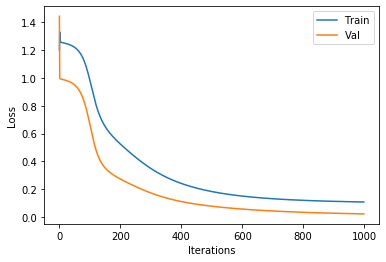

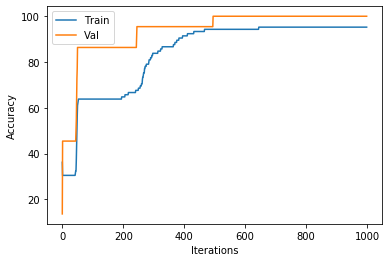

In [21]:
model1.print_results()

In [22]:
model1.test(X_test, Y_test)

Loss =  0.12623702839007542
Accuracy =  95.65217391304348


## Wine dataset

In [23]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=';')

In [24]:
y = np.array(pd.get_dummies(data[data['quality'].isin([4,5,6])]['quality']))
X = np.array(data[data['quality'].isin([4,5,6])])[:,:11]

X, Y = shuffle(X, y, random_state=2021)

# Split train/val
n_train = int(0.7*X.shape[0])

n_val = n_train + int(0.15*X.shape[0])

X_train = X[:n_train]
Y_train = Y[:n_train]

X_val = X[n_train:n_val]
Y_val = Y[n_train: n_val]

X_test = X[n_val:]
Y_test = Y[n_val:]

In [29]:
model2 = Model([11, 2, 4, 3])

In [30]:
Train = False
file = 'wine.pkl'
    
if Train:
    model2.fit(X_train, Y_train, X_val, Y_val, 1e-4, 500)
    pickle.dump(model2, open(file, 'wb'))
else:
    model2 = pickle.load(open(file, 'rb'))  

Iteration number 10 / 500: Loss: 0.998788, Acc: 38.285928, Val. Loss: 1.004258, Val. Acc: 38.286713
Iteration number 20 / 500: Loss: 0.931783, Acc: 57.672156, Val. Loss: 0.942328, Val. Acc: 56.293706
Iteration number 30 / 500: Loss: 0.894743, Acc: 57.672156, Val. Loss: 0.909026, Val. Acc: 56.293706
Iteration number 40 / 500: Loss: 0.872849, Acc: 57.672156, Val. Loss: 0.889945, Val. Acc: 56.293706
Iteration number 50 / 500: Loss: 0.858935, Acc: 57.672156, Val. Loss: 0.878204, Val. Acc: 56.293706
Iteration number 60 / 500: Loss: 0.849509, Acc: 57.672156, Val. Loss: 0.870500, Val. Acc: 56.293706
Iteration number 70 / 500: Loss: 0.842792, Acc: 57.672156, Val. Loss: 0.865181, Val. Acc: 56.293706
Iteration number 80 / 500: Loss: 0.837823, Acc: 57.672156, Val. Loss: 0.861370, Val. Acc: 56.293706
Iteration number 90 / 500: Loss: 0.834042, Acc: 57.672156, Val. Loss: 0.858564, Val. Acc: 56.293706
Iteration number 100 / 500: Loss: 0.831103, Acc: 57.672156, Val. Loss: 0.856457, Val. Acc: 56.293706

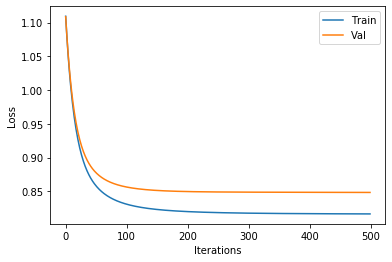

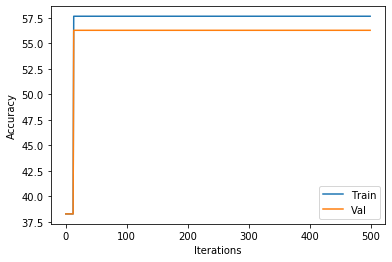

In [31]:
model2.print_results()

In [32]:
model2.test(X_test, Y_test)

Loss =  0.8165950464466671
Accuracy =  58.362369337979096
